# MAST30034 Project 2: Rental Analysis and Insights for Victoria

## Overview
This notebook performs an in-depth analysis of rental properties in Victoria using a cleaned dataset of property attributes, historical rent trends, demographic information, and livability metrics. The analysis aims to provide insights into:

1. **Key Features Influencing Rental Prices**: 
   - Analyzed internal and external features to determine the most significant factors affecting rent.
   - Plotted distributions, correlations, and regression lines for key property features like `beds`, `baths`, and `cost`.

2. **Predicted Growth Rates for Suburbs**:
   - Identified the top 10 suburbs with the highest **predicted population growth** using historical demographic data.
   - Visualized growth rates and how they relate to rent prices.

3. **Most Livable and Affordable Suburbs**:
   - Compared **livability and affordability scores** across suburbs to highlight areas offering the best balance between quality of life and cost.
   - Visualized relationships between **rent cost, livability, and affordability**.

## Methodology
1. **Data Preprocessing**:
   - Loaded the data using PySpark.
   - Dropped unnecessary columns, converted data types, and filtered for specific attributes (`beds <= 5`, `parkings <= 4`, `100 <= cost <= 800`).

2. **Exploratory Data Analysis**:
   - **Distributions**: Plotted histograms to observe skewness, central tendency, and spread of various property features.
   - **Outlier Analysis**: Identified significant outliers in cost, number of beds, and amenities.
   - **Correlation Analysis**: Generated heatmaps to find relationships among internal and external property features.

3. **Key Visualizations**:
   - **Growth Rate vs Rent Cost**: Illustrated how predicted growth rates relate to current rental prices.
   - **Beds vs Rent Cost**: Showed a slight positive correlation between the number of bedrooms and rent cost.
   - **Livability and Affordability Scores**: Highlighted top suburbs with high livability and affordability through bar charts and scatter plots.

## Observations
### Rental Cost Analysis
- **Higher Bedrooms, Higher Rent**: Rent cost generally increases with more bedrooms (`5 beds` have the highest median rent).
- **Outliers**: Significant outliers for rent exist, especially for properties with more rooms, indicating variability in demand or quality.

### Livability vs Affordability
- **Negative Correlation**: Rent costs negatively correlate with affordability scores, as expected.
- **Livability Impact**: High livability scores do not always correspond to low rent or high affordability, suggesting complex dynamics beyond just property features.

### Predicted Growth Suburbs
- **Top Growth Areas**: Identified the top 10 suburbs with the highest predicted growth rates, indicating potential future hotspots for rental investment.
- **Low-Growth, High Rent**: Some suburbs with low growth rates still have high rent costs, pointing towards other factors affecting rental desirability.

## Key Conclusions
- **Internal Features Impact Rent**: Number of bedrooms, bathrooms, and specific amenities (e.g., air conditioning) strongly influence rent costs.
- **Amenities vs Cost**: External amenities like parks, schools, and supermarkets have a weaker impact on rent prices.
- **Growth as an Investment Indicator**: Areas with high growth potential may not always align with high rents, indicating potential for rental market expansion.

Produced with assistance from ChatGPT, powered by OpenAI.

In [2]:
from pyspark.sql import SparkSession, Row
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import seaborn as sns
from pyspark.sql import functions as F

In [3]:
# Initialize Spark session
spark = (
    SparkSession.builder.appName("MAST30034 Project 2")
    .config("spark.sql.repl.eagerEval.enabled", True)
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .getOrCreate()
)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/10/11 03:34:38 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
# Load the data from the parquet file
prop_data_df = spark.read.parquet("../data/curated/prop_cleaned1.parquet")
prop_data_df.limit(5)

24/10/11 03:34:50 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-----------+--------------------+--------------------+----+-----+--------+----+----------+--------------------+---------+-----+------------------+----------+----------------+-----------+--------------+--------+-------+-------+------------+---+---------+--------------+------------------+------------+----------------+--------------+--------------------+-------------+-------------+-------+-----+----------------+------------+----------------+------------+---------------+-----------+------------------------------+---------------------------------+---------------------------+-------------+--------------------------------+-----------------------------------+-----------------------------+------------------+-------------------------------------+----------------------------------------+----------------------------------+---------------+----------------------------------+-------------------------------------+-------------------------------+------------------------+-------------------------------------------+----------------------------------------------+----------------------------------------+---------+----------------------------+-------------------------------+-------------------------+--------------------+---------------------------------------+------------------------------------------+------------------------------------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+------------------+-----------------+------------------+------------------+------------------+-----------------+-----------------+-----------------+-----------------+------------------+-----------------+-----------------+-----------------+-----------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+-----------------+------------------+-----------------+----------------+------------------+------------------+------------------+------------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+-------------------+-----------------+------------------+-----------------------------+---------------------------+-------------------+-----------------+
|postal_code|                name|        property_url|beds|baths|parkings|cost|unit_floor|              street|   suburb|state|built_in_wardrobes|dishwasher|air_conditioning|floorboards|secure_parking|intercom|heating|ensuite|balcony_deck|gym|furnished|close_to_shops|close_to_transport|fully_fenced|close_to_schools|ducted_heating|split_system_heating|swimming_pool|remote_garage|balcony|study|garden_courtyard|pets_allowed|internal_laundry|alarm_system|prop_type_index|parks_count|parks_average_travel_time_mins|parks_average_travel_distance_kms|parks_time_distance_product|schools_count|schools_average_travel_time_mins|schools_average_travel_distance_kms|schools_time_distance_product|supermarkets_count|supermarkets_average_travel_time_mins|supermarkets_average_travel_distance_kms|supermarkets_time_distance_product|hospitals_count

In [5]:
# Get the number of rows
num_rows = prop_data_df.count()

# Get the number of columns
num_columns = len(prop_data_df.columns)

# Print the shape
print(f"Shape of prop_data_df: ({num_rows}, {num_columns})")

Shape of prop_data_df: (11479, 210)


In [6]:
# Print the schema to see the column names and types
prop_data_df.printSchema()

root
 |-- postal_code: string (nullable = true)
 |-- name: string (nullable = true)
 |-- property_url: string (nullable = true)
 |-- beds: integer (nullable = true)
 |-- baths: integer (nullable = true)
 |-- parkings: integer (nullable = true)
 |-- cost: integer (nullable = true)
 |-- unit_floor: string (nullable = true)
 |-- street: string (nullable = true)
 |-- suburb: string (nullable = true)
 |-- state: string (nullable = true)
 |-- built_in_wardrobes: integer (nullable = true)
 |-- dishwasher: integer (nullable = true)
 |-- air_conditioning: integer (nullable = true)
 |-- floorboards: integer (nullable = true)
 |-- secure_parking: integer (nullable = true)
 |-- intercom: integer (nullable = true)
 |-- heating: integer (nullable = true)
 |-- ensuite: integer (nullable = true)
 |-- balcony_deck: integer (nullable = true)
 |-- gym: integer (nullable = true)
 |-- furnished: integer (nullable = true)
 |-- close_to_shops: integer (nullable = true)
 |-- close_to_transport: integer (nulla

- **Property Features**: Includes details like `beds`, `baths`, `parkings`, and amenities (e.g., `air_conditioning`, `furnished`).
- **Location Data**: Fields like `parks_count`, `schools_count`, and travel times measure proximity to key amenities.
- **Rental Trends**: Quarterly rental data from 2000 to 2023 allows for historical rent analysis.
- **Demographics**: Population growth and yearly increases give insight into area development.
- **Scores**: `normalized_livability_score`, `affordability_score`, and `combined_score` provide key metrics for livability and affordability.

In [7]:
# Drop the columns that are not needed
prop_data_df = prop_data_df.drop("unit_floor", "street", "suburb", "state")

# Convert postal_code to integer
prop_data_df = prop_data_df.withColumn("postal_code", col("postal_code").cast("int"))

## OUTLIER ANALYSIS

In [8]:
# Inspect descriptive statistics of the data
prop_data_df.describe()

24/10/11 03:35:39 WARN DAGScheduler: Broadcasting large task binary with size 1895.4 KiB
24/10/11 03:36:01 WARN DAGScheduler: Broadcasting large task binary with size 1895.4 KiB


+-------+------------------+--------------------+--------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+------------------+-------------------+-------------------+-------------------+------------------+-------------------+--------------------+--------------------+--------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------------+------------------+-----------------+------------------------------+---------------------------------+---------------------------+------------------+--------------------------------+-----------------------------------+-----------------------------+------------------+-------------------------------------+----------------------------------------+----------------------------------+------------------+----------------------------------+-------------------------------------+-------------------------------+------------------------+-------------------------------------------+----------------------------------------------+----------------------------------------+---------+----------------------------+-------------------------------+-------------------------+--------------------+---------------------------------------+------------------------------------------+------------------------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+-----------------+------------------+------------------+------------------+------------------+-----------------+------------------+-----------------+------------------+------------------+-----------------+-----------------+-----------------+------------------+-----------------+------------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+------------------+-----------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+-----------------+-----------------+-----------------+------------------+------------------+------------------+------------------+------------------+-----------------+-----------------+------------------+------------------+-----------------+-----------------+-----------------+-----------------+------------------+-----------------+-----------------+------------------+------------------+-----------------+------------------+-----------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+-----------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+-------------------+------------------+-------------------+-------------------+-------------------+------------------+------------------+-

- **Property Characteristics**: 
  - Properties vary widely in terms of size (`beds`, `baths`, `parkings`), with a maximum of 50 beds and 20 parkings.
  - Amenities such as `air_conditioning`, `built_in_wardrobes`, and `balcony` are commonly included.

- **Rent Data**:
  - The average cost is approximately $106,000 with a large standard deviation, suggesting diverse rental price ranges.
  - Rent trends are available from **2000 to 2023**, with values showing steady increases.

- **Livability Metrics**: 
  - **Normalized Livability Scores** range from 0 to 100, based on proximity to amenities like parks, schools, and supermarkets.
  - **Affordability Scores** reflect rent-to-income ratios, where lower ratios result in higher scores, up to 100.

- **Demographics**:
  - Population growth and rent increases show regional development, with year-on-year population data from 2001 to 2023.

In [9]:
# Define the columns to calculate percentiles for
columns = ["beds", "baths", "parkings", "cost"]

# Define the percentiles to calculate
percentiles = [0.01, 0.05, 0.1, 0.2, 0.9, 0.95, 0.97, 0.99, 0.995, 0.999]

# Calculate percentiles for each column
percentile_values = {col: prop_data_df.approxQuantile(col, percentiles, 0.001) for col in columns}

# Prepare data for DataFrame creation
rows = []
for col, values in percentile_values.items():
    data = {f"{(p*100)} th_percentile": val for p, val in zip(percentiles, values)}
    row = Row(column=col, **data)
    rows.append(row)

# Create DataFrame from the list of Row objects
percentile_df = spark.createDataFrame(rows)

# Show the DataFrame
percentile_df

+--------+-----------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|  column|1.0 th_percentile|5.0 th_percentile|10.0 th_percentile|20.0 th_percentile|90.0 th_percentile|95.0 th_percentile|97.0 th_percentile|99.0 th_percentile|99.5 th_percentile|99.9 th_percentile|
+--------+-----------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|    beds|              1.0|              1.0|               1.0|               2.0|               4.0|               4.0|               4.0|               5.0|               5.0|              50.0|
|   baths|              1.0|              1.0|               1.0|               1.0|               2.0|               3.0|               3.0|               3.0|               4.0|               6.0|
|parkings|              1.0|              1.0|               1.0|               1.0|               2.0|               2.0|               3.0|               4.0|               5.0|              20.0|
|    cost|             69.0|            355.0|             420.0|             480.0|             900.0|            1150.0|            1300.0|            1800.0|            2200.0|      4.04040527E8|
+--------+-----------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+

### Observations:

- **Beds**:
  - Most properties (up to the 90th percentile) have **1-4 beds**.
  - Extreme outliers exist, with the 99.9th percentile showing **50 beds**.

- **Baths**:
  - Properties typically have **1-2 baths**, with some in the upper percentiles having **3-4 baths**.
  - Outliers exist at the 99.9th percentile with up to **6 baths**.

- **Parkings**:
  - Most properties offer **1-2 parking spaces**. 
  - The 99th percentile and above include outliers with up to **20 parking spaces**.

- **Cost**:
  - Rent prices vary significantly, with the 10th percentile starting at **$420** and the 90th percentile reaching **$900**.
  - The 99.9th percentile shows extreme outliers, with rent prices spiking to **over $400 million**, likely due to data entry anomalies.

In [10]:
from pyspark.sql.functions import col
# Filtering the DataFrame to include properties that:
prop_data_df = prop_data_df.filter(
    (col("beds") <= 5) &           # Filter properties with 5 or fewer beds
    (col("parkings") <= 4) &       # Filter properties with 4 or fewer parking spaces
    (col("cost") <= 800) &         # Filter properties with cost up to 800
    (col("cost") >= 100)           # Filter properties with cost at least 100
)

# Count the number of rows after filtering to see how many properties meet the criteria
prop_data_df.count()

9621

In [11]:
prop_data_df.columns

['postal_code',
 'name',
 'property_url',
 'beds',
 'baths',
 'parkings',
 'cost',
 'built_in_wardrobes',
 'dishwasher',
 'air_conditioning',
 'floorboards',
 'secure_parking',
 'intercom',
 'heating',
 'ensuite',
 'balcony_deck',
 'gym',
 'furnished',
 'close_to_shops',
 'close_to_transport',
 'fully_fenced',
 'close_to_schools',
 'ducted_heating',
 'split_system_heating',
 'swimming_pool',
 'remote_garage',
 'balcony',
 'study',
 'garden_courtyard',
 'pets_allowed',
 'internal_laundry',
 'alarm_system',
 'prop_type_index',
 'parks_count',
 'parks_average_travel_time_mins',
 'parks_average_travel_distance_kms',
 'parks_time_distance_product',
 'schools_count',
 'schools_average_travel_time_mins',
 'schools_average_travel_distance_kms',
 'schools_time_distance_product',
 'supermarkets_count',
 'supermarkets_average_travel_time_mins',
 'supermarkets_average_travel_distance_kms',
 'supermarkets_time_distance_product',
 'hospitals_count',
 'hospitals_average_travel_time_mins',
 'hospitals

In [12]:
prop_data_df.write.parquet("../data/curated/prop_cleaned2.parquet", mode="overwrite")

## DISTRIBUTIONS

In [13]:
sns.set(style="whitegrid")

In [14]:
# Load the data from the parquet file
df_prop = pd.read_parquet('../data/curated/prop_cleaned2.parquet')

In [15]:
df_prop.dtypes

postal_code                        int32
name                              object
property_url                      object
beds                               int32
baths                              int32
                                  ...   
increase_2023_pop                float64
mean_population_increase_rate    float64
normalized_livability_score        int32
affordability_score              float32
combined_score                   float64
Length: 206, dtype: object

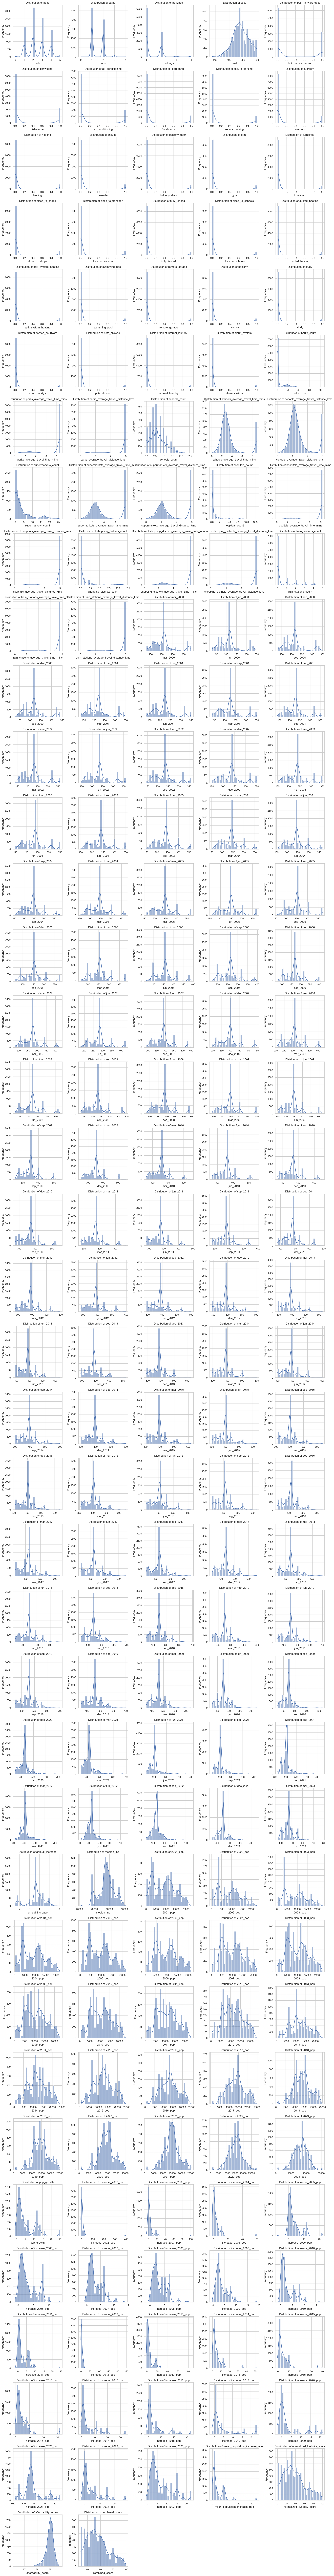

In [16]:
# List of columns to check for distribution
columns_to_check = [
    'beds', 'baths', 'parkings', 'cost', 
    'built_in_wardrobes', 'dishwasher', 'air_conditioning', 'floorboards', 'secure_parking', 'intercom',
    'heating', 'ensuite', 'balcony_deck', 'gym', 'furnished', 'close_to_shops', 'close_to_transport',
    'fully_fenced', 'close_to_schools', 'ducted_heating', 'split_system_heating', 'swimming_pool',
    'remote_garage', 'balcony', 'study', 'garden_courtyard', 'pets_allowed', 'internal_laundry', 'alarm_system',
    'parks_count', 'parks_average_travel_time_mins', 'parks_average_travel_distance_kms', 
    'schools_count', 'schools_average_travel_time_mins', 'schools_average_travel_distance_kms', 
    'supermarkets_count', 'supermarkets_average_travel_time_mins', 'supermarkets_average_travel_distance_kms', 
    'hospitals_count', 'hospitals_average_travel_time_mins', 'hospitals_average_travel_distance_kms', 
    'shopping_districts_count', 'shopping_districts_average_travel_time_mins', 'shopping_districts_average_travel_distance_kms',
    'train_stations_count', 'train_stations_average_travel_time_mins', 'train_stations_average_travel_distance_kms',
    'mar_2000', 'jun_2000', 'sep_2000', 'dec_2000', 'mar_2001', 'jun_2001', 'sep_2001', 'dec_2001', 
    'mar_2002', 'jun_2002', 'sep_2002', 'dec_2002', 'mar_2003', 'jun_2003', 'sep_2003', 'dec_2003',
    'mar_2004', 'jun_2004', 'sep_2004', 'dec_2004', 'mar_2005', 'jun_2005', 'sep_2005', 'dec_2005', 
    'mar_2006', 'jun_2006', 'sep_2006', 'dec_2006', 'mar_2007', 'jun_2007', 'sep_2007', 'dec_2007', 
    'mar_2008', 'jun_2008', 'sep_2008', 'dec_2008', 'mar_2009', 'jun_2009', 'sep_2009', 'dec_2009',
    'mar_2010', 'jun_2010', 'sep_2010', 'dec_2010', 'mar_2011', 'jun_2011', 'sep_2011', 'dec_2011',
    'mar_2012', 'jun_2012', 'sep_2012', 'dec_2012', 'mar_2013', 'jun_2013', 'sep_2013', 'dec_2013', 
    'mar_2014', 'jun_2014', 'sep_2014', 'dec_2014', 'mar_2015', 'jun_2015', 'sep_2015', 'dec_2015',
    'mar_2016', 'jun_2016', 'sep_2016', 'dec_2016', 'mar_2017', 'jun_2017', 'sep_2017', 'dec_2017',
    'mar_2018', 'jun_2018', 'sep_2018', 'dec_2018', 'mar_2019', 'jun_2019', 'sep_2019', 'dec_2019',
    'mar_2020', 'jun_2020', 'sep_2020', 'dec_2020', 'mar_2021', 'jun_2021', 'sep_2021', 'dec_2021',
    'mar_2022', 'jun_2022', 'sep_2022', 'dec_2022', 'mar_2023', 'annual_increase', 'median_inc', 
    '2001_pop', '2002_pop', '2003_pop', '2004_pop', '2005_pop', '2006_pop', '2007_pop', '2008_pop', 
    '2009_pop', '2010_pop', '2011_pop', '2012_pop', '2013_pop', '2014_pop', '2015_pop', '2016_pop', 
    '2017_pop', '2018_pop', '2019_pop', '2020_pop', '2021_pop', '2022_pop', '2023_pop', 
    'pop_growth', 'increase_2002_pop', 'increase_2003_pop', 'increase_2004_pop', 'increase_2005_pop',
    'increase_2006_pop', 'increase_2007_pop', 'increase_2008_pop', 'increase_2009_pop', 'increase_2010_pop', 
    'increase_2011_pop', 'increase_2012_pop', 'increase_2013_pop', 'increase_2014_pop', 'increase_2015_pop', 
    'increase_2016_pop', 'increase_2017_pop', 'increase_2018_pop', 'increase_2019_pop', 'increase_2020_pop',
    'increase_2021_pop', 'increase_2022_pop', 'increase_2023_pop', 'mean_population_increase_rate', 
    'normalized_livability_score', 'affordability_score', 'combined_score'
]

# Set up the number of rows and columns for subplots dynamically
num_cols = 5
num_rows = (len(columns_to_check) + num_cols - 1) // num_cols  # Calculate the number of rows needed

plt.figure(figsize=(20, num_rows * 4))  # Adjust the figure size based on the number of rows

# Loop through each column and plot its distribution
for i, col in enumerate(columns_to_check, 1):
    plt.subplot(num_rows, num_cols, i)  # Create subplots dynamically
    sns.histplot(df_prop[col], bins=30, kde=True)  # Plot histogram with KDE
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

1. **Skewed Distributions**: Several columns, particularly those related to property amenities (e.g., `heating`, `secure_parking`), show highly skewed distributions with most values concentrated near 0 or 1.

2. **Normal Distributions**: Some columns, such as **rental cost** and **population growth rates**, exhibit more bell-shaped or normal-like distributions, although there are outliers.

3. **Sparse Data**: Features like `swimming_pool`, `gym`, and `alarm_system` have very few entries, indicating these amenities are rare across the dataset.

4. **Outliers**: Certain columns (e.g., `cost`, `beds`, `parkings`) show significant outliers at the upper range, which might need special handling.

5. **Multi-modal Distributions**: Some features, such as **cost** and **population**, may exhibit multi-modal tendencies, suggesting potential clustering or distinct subgroups within the data.

### Central Tendency and Spread

The histogram shows a **unimodal distribution** with a peak around **200-300 units** of cost (assuming this might be in thousands or as per your specific measurement unit). The data is **right-skewed**, indicating that most properties are clustered at the lower end of the cost spectrum, with fewer properties having a higher cost.

### High Frequency of Lower Costs

There's a significant frequency of properties costing between **100 and 400 units**, which might represent the more affordable segment of the market.

### Long Tail to the Right

The long tail extending towards the higher cost values (over **500 units**) suggests the presence of **high-end properties** that are less frequent but significantly more expensive than the typical properties in the dataset. This tail includes some properties that approach **2000 units** in cost, representing the **luxury market segment**.

### Potential Outliers

Properties with costs approaching **2000 units** could be considered **outliers** compared to the majority of the data, or they might represent a distinct segment of the market (e.g., **luxury real estate**).

In [17]:
df_prop = df_prop.select_dtypes(exclude=['object'])

In [18]:
correlation_matrix = df_prop.corr()  # Compute the correlation matrix

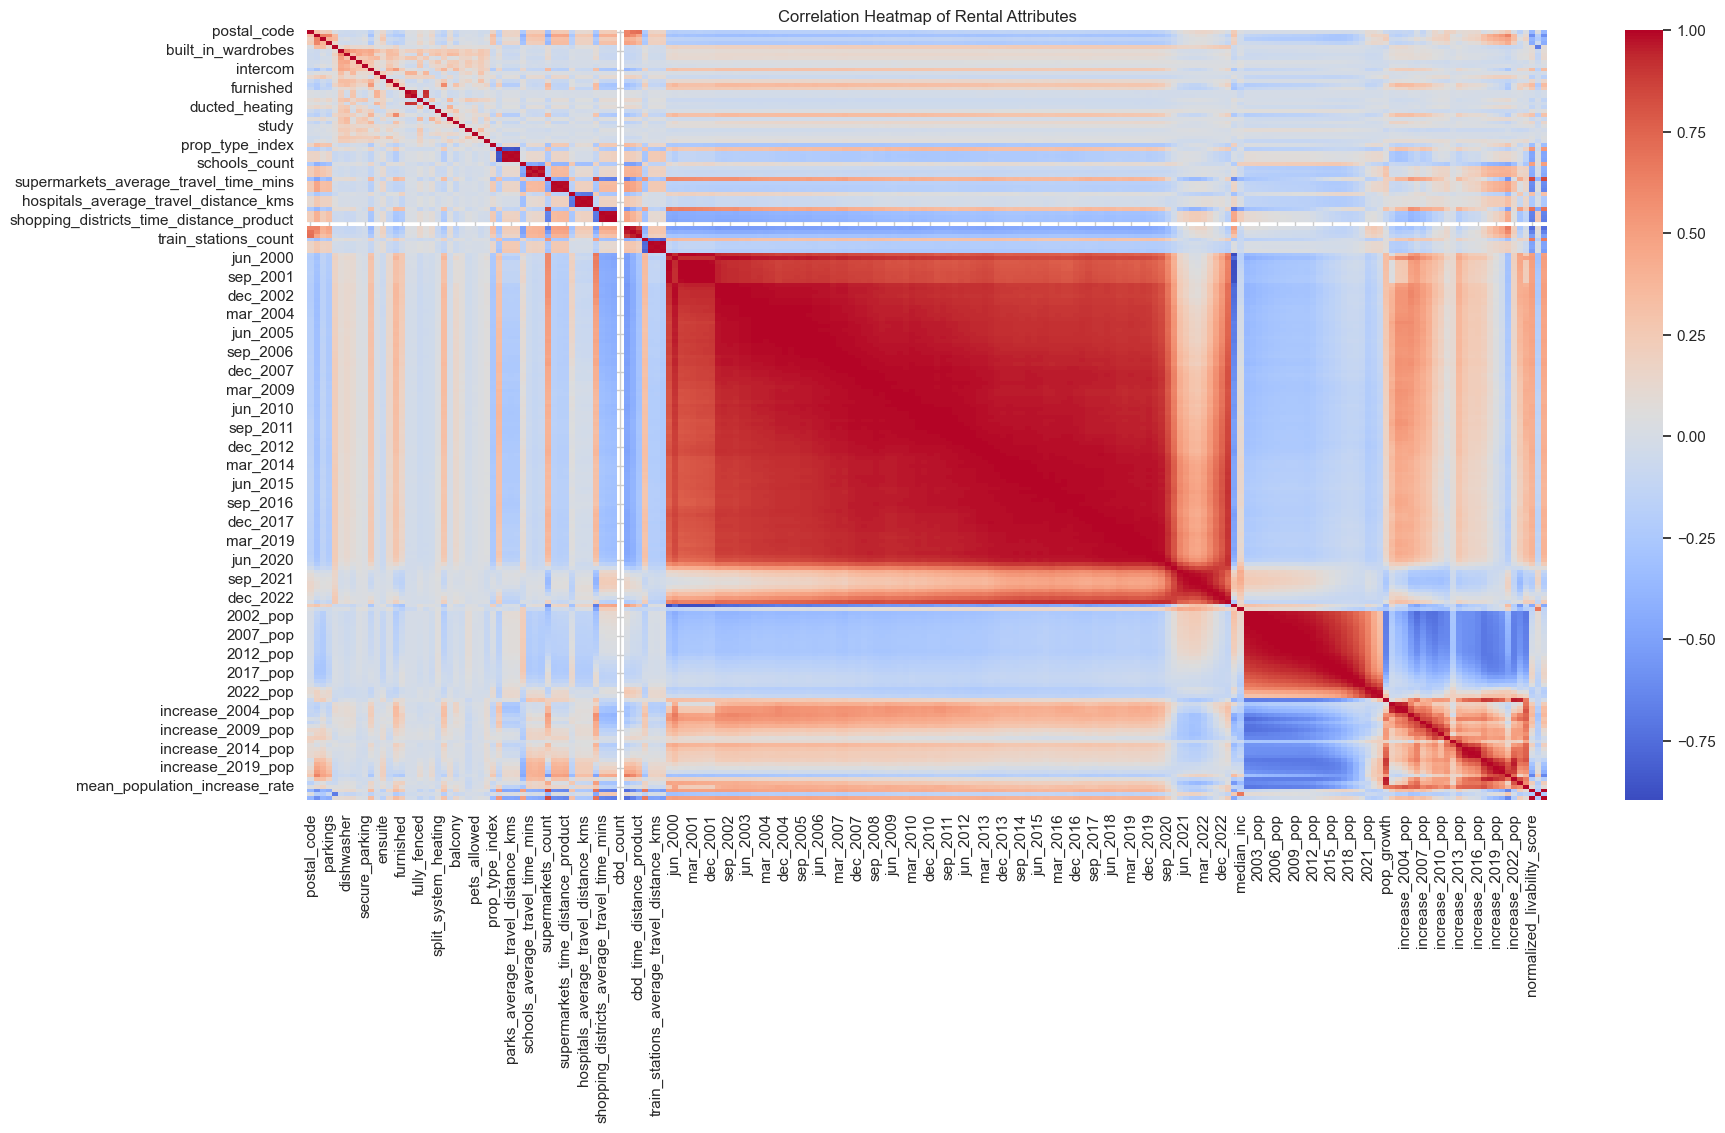

In [19]:
# Create and display the heatmap
plt.figure(figsize=(20, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', cbar=True)
plt.title('Correlation Heatmap of Rental Attributes')
plt.show()

### Correlation Heatmap Observations:

1. **Strong Positive Correlations**:
   - Population columns (e.g., `2001_pop`, `2002_pop`, `2022_pop`) show strong positive correlations with each other, indicating that population changes over time follow a consistent trend.
   - Cost-related columns and rental price trends over different quarters exhibit positive correlations, reflecting rental price increases over time.

2. **Negative Correlations**:
   - There is a notable negative correlation between population increase rate (e.g., `increase_2004_pop`, `increase_2010_pop`) and population count in certain years. This may indicate that areas with lower starting populations have higher growth rates.

3. **Moderate Correlations**:
   - Some amenity-related features, such as proximity to parks, hospitals, and schools, show moderate correlations with livability and affordability scores, suggesting they moderately influence quality of life in an area.
   - The correlation between `normalized_livability_score` and amenities like `schools_count` and `supermarkets_count` also stands out, but the strength is not extreme.

4. **Isolated or Weak Correlations**:
   - Several features related to amenities such as `furnished`, `intercom`, and `heating` show weaker correlations with the main attributes, indicating they have less influence on the overall scoring systems.

5. **Distinct Blocks**:
   - Population-related features and historical rent prices form distinct blocks in the heatmap, with high internal correlations, suggesting strong interdependencies within these groups of variables.

6. **Outliers**:
   - Certain features, like `mean_population_increase_rate`, have weaker correlations with most other variables, indicating these may have unique or independent patterns.

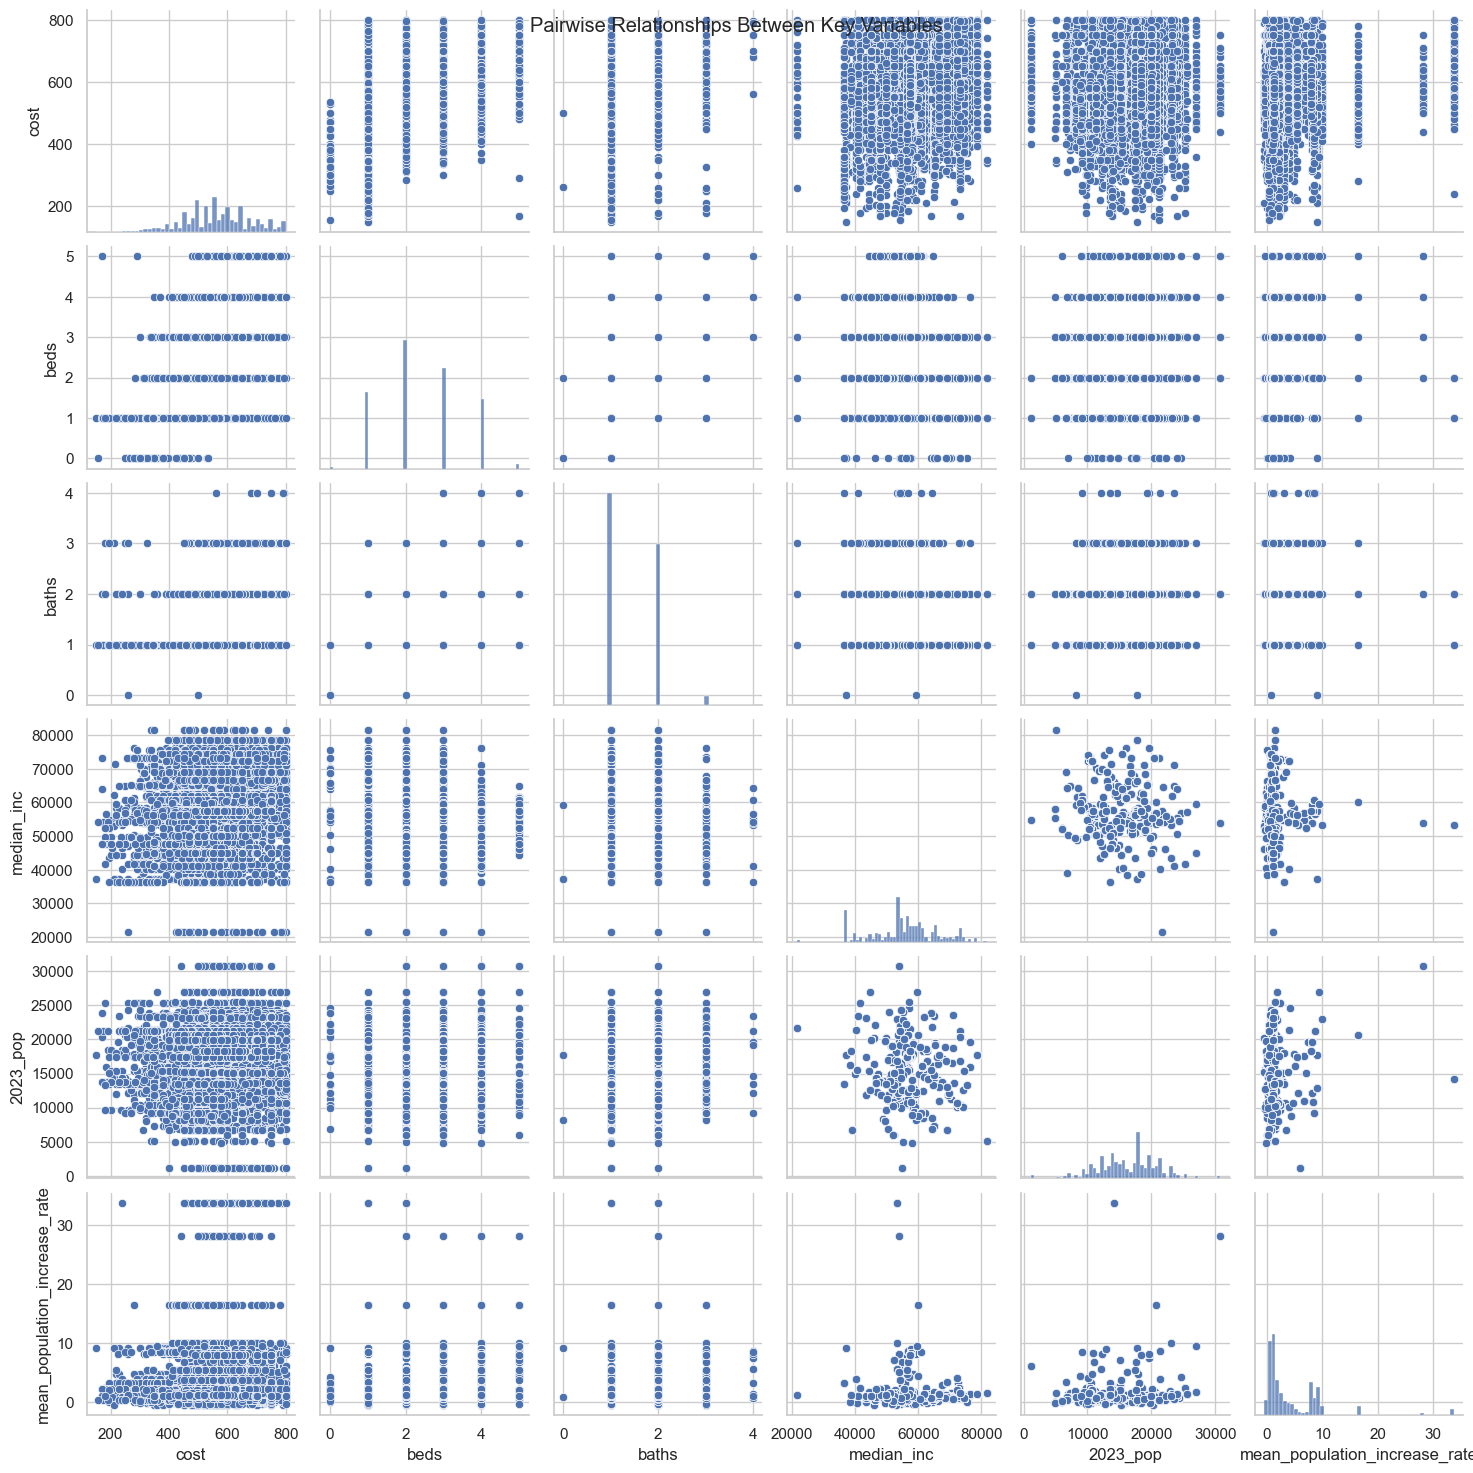

In [20]:
# Selecting a subset of relevant variables
selected_columns = df_prop[['cost', 'beds', 'baths', 'median_inc', '2023_pop', 'mean_population_increase_rate']]
sns.pairplot(selected_columns)
plt.suptitle('Pairwise Relationships Between Key Variables')
plt.show()

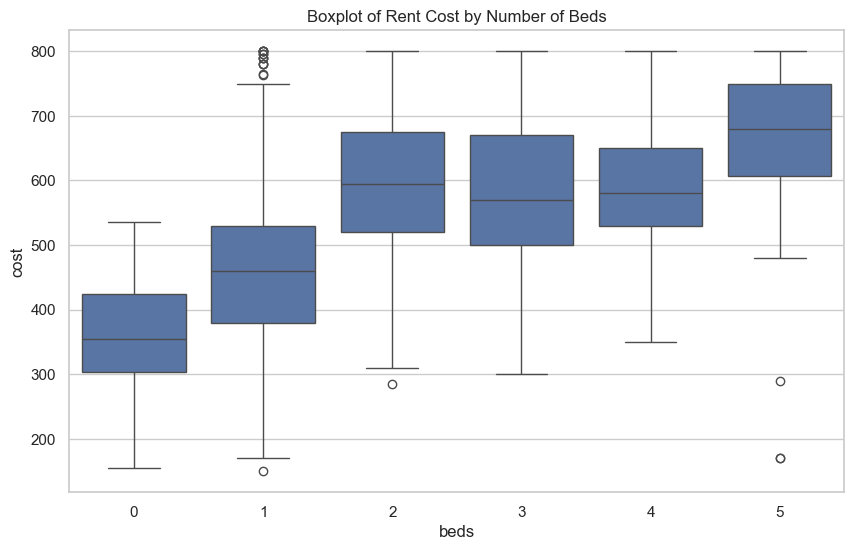

In [21]:
# Boxplot of rent cost grouped by number of beds
plt.figure(figsize=(10, 6))
sns.boxplot(x='beds', y='cost', data=df_prop)
plt.title('Boxplot of Rent Cost by Number of Beds')
plt.show()

1. **Median Rent Increases**: Rent cost increases with the number of bedrooms, with properties having 5 beds showing the highest median rent.
2. **Higher Rent Variability**: Rent variability is higher for properties with more beds, especially for 4 and 5-bedroom properties.
3. **Outliers**: Outliers are present across all bed categories, indicating exceptional rent values both on the higher and lower ends.
4. **Bedroom Count as a Key Factor**: Number of beds is a strong determinant of rent cost.

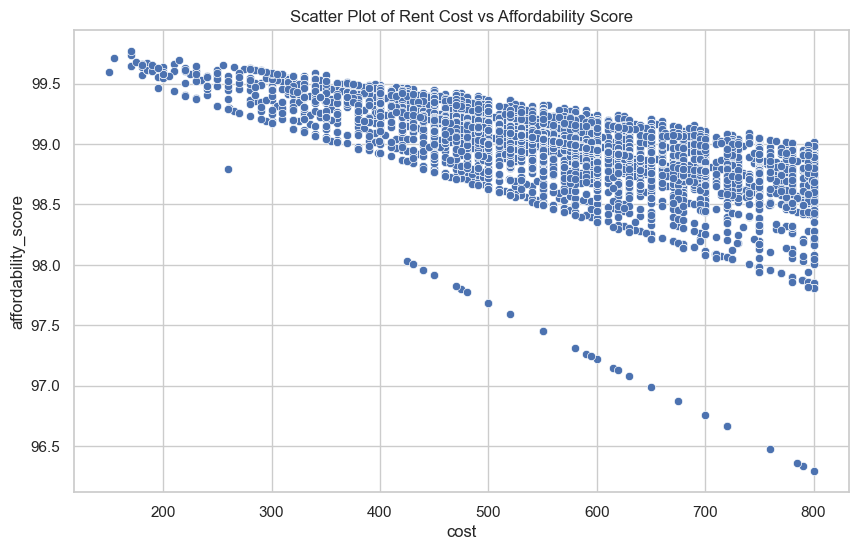

In [22]:
# Scatter plot of cost vs affordability score
plt.figure(figsize=(10, 6))
sns.scatterplot(x='cost', y='affordability_score', data=df_prop)
plt.title('Scatter Plot of Rent Cost vs Affordability Score')
plt.show()


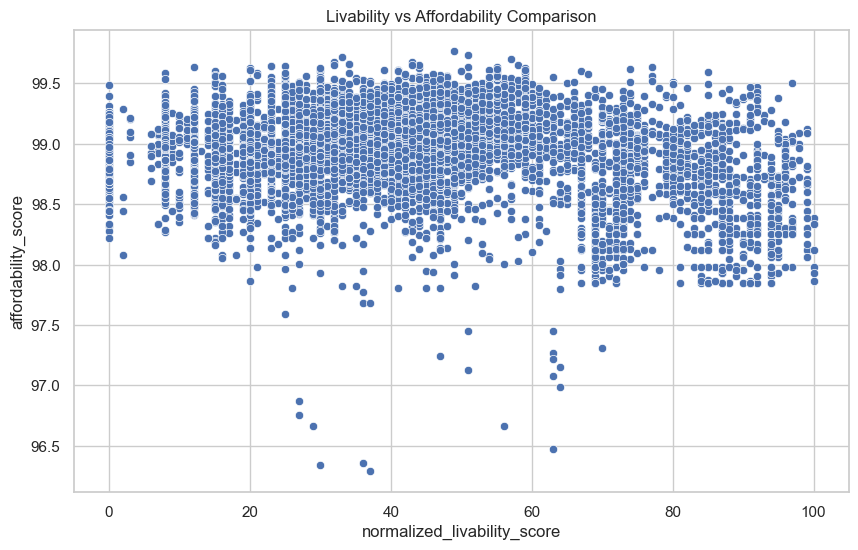

In [23]:
# Scatter plot of normalized livability score vs affordability score
plt.figure(figsize=(10, 6))
sns.scatterplot(x='normalized_livability_score', y='affordability_score', data=df_prop)
plt.title('Livability vs Affordability Comparison')
plt.show()


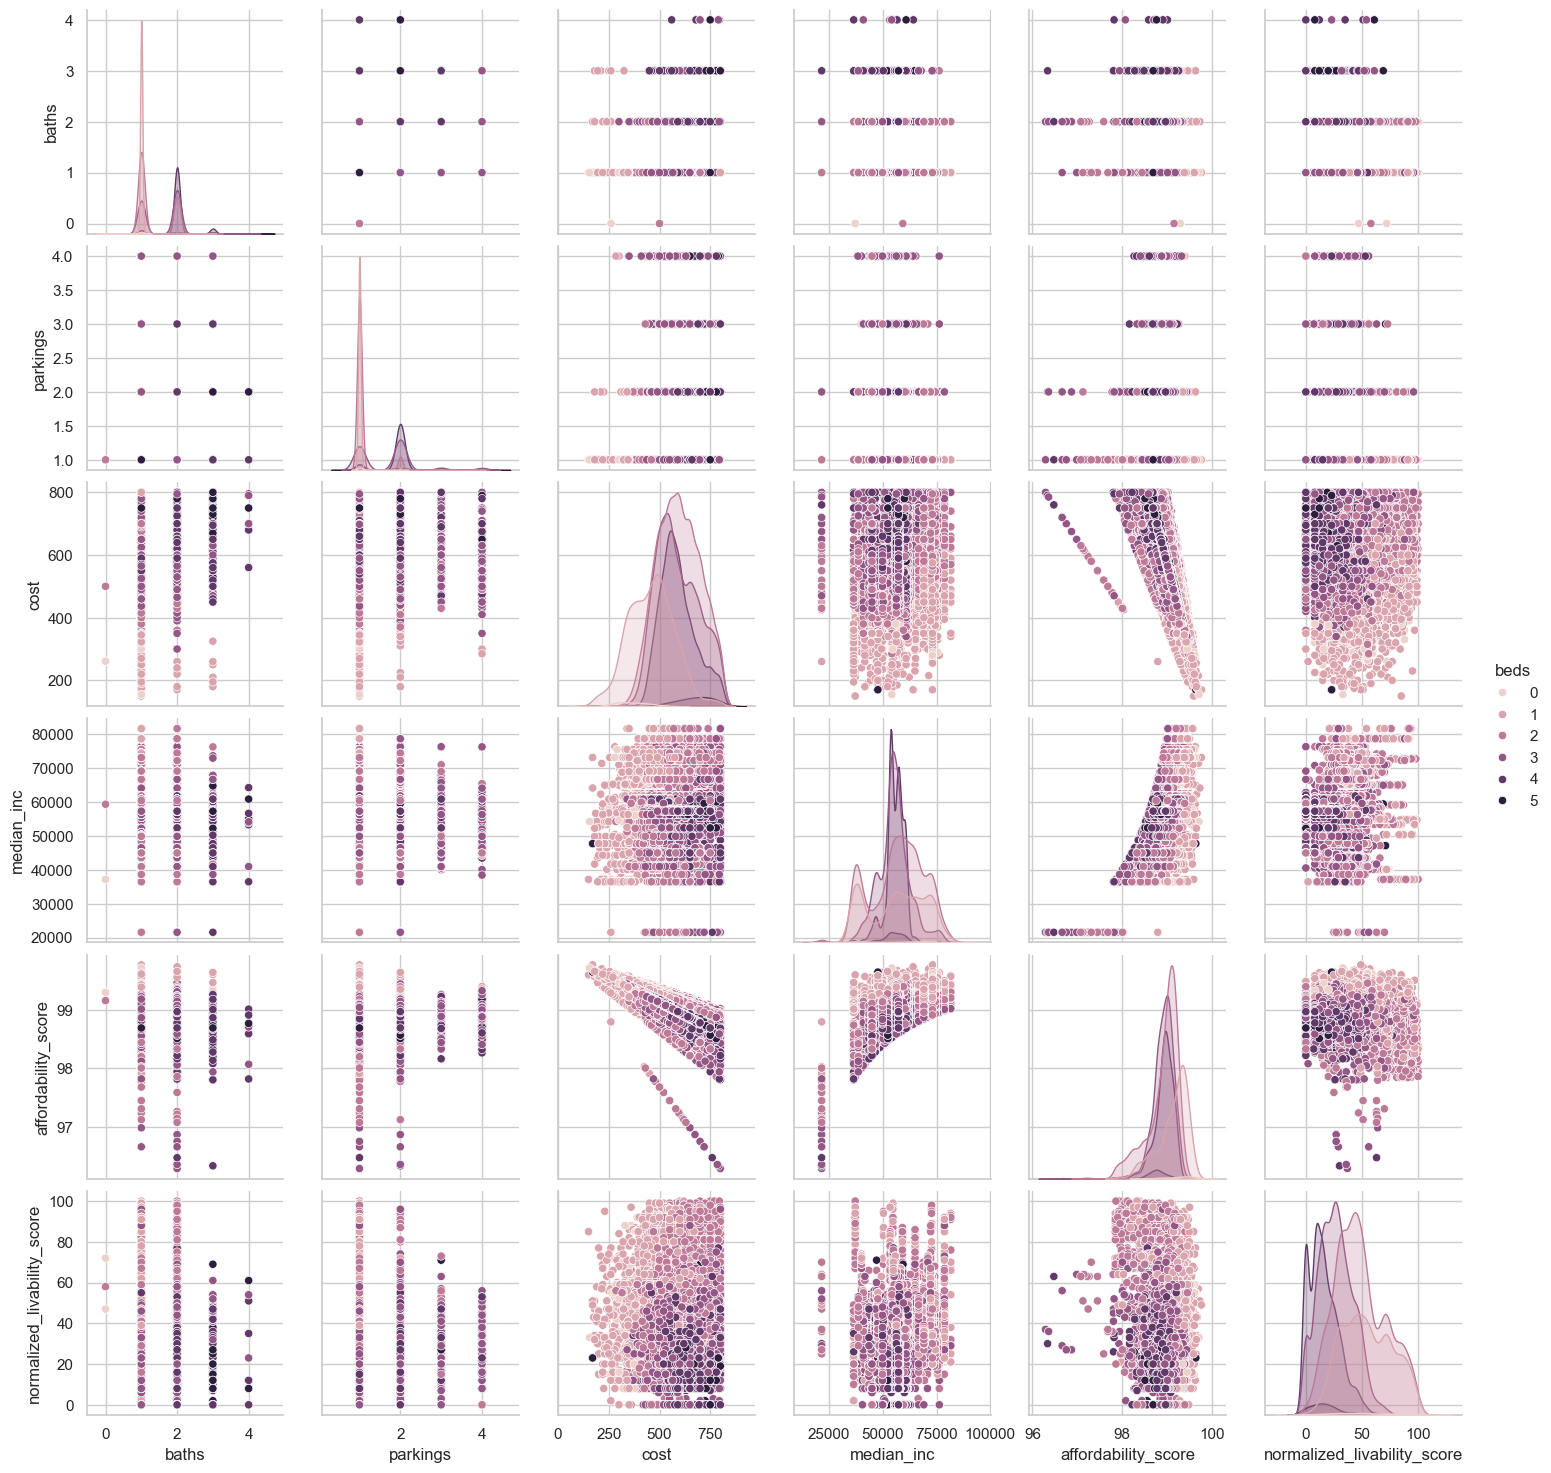

In [24]:
# Selecting key variables for pairplot
key_features = ['beds', 'baths', 'parkings', 'cost', 'median_inc', 'affordability_score', 'normalized_livability_score']

# Pairplot to visualize relationships between key features
sns.pairplot(df_prop[key_features], diag_kind='kde', hue='beds')  # Use 'beds' as a grouping hue
plt.show()


1. **Relationship Between Features**:
   - There are visible relationships between certain features, such as `median_inc` (median income) and `affordability_score`. Higher income is generally associated with higher affordability scores.
   - There appears to be a negative relationship between `cost` and `affordability_score`, as expected, indicating that as rent costs increase, affordability decreases.
  
2. **Cost vs Other Features**:
   - `cost` appears to have a spread across different values for features like `beds`, `baths`, and `parkings`. Notably, `cost` seems to increase with more `beds` and `baths`.
  
3. **Affordability and Livability Scores**:
   - There is no clear pattern between `affordability_score` and `normalized_livability_score`, indicating that these two metrics may be capturing different aspects of desirability in properties.
   - `normalized_livability_score` shows a wide distribution and does not seem strongly correlated with other features.

4. **Density Plots**:
   - The diagonal density plots show skewed distributions for some features. For example, `cost` and `median_inc` both show right-skewed distributions, indicating that most properties fall into a lower price or income range.
  
5. **Distribution by Bed Count**:
   - The hue applied (`beds` as the legend) reveals that properties with fewer bedrooms are more frequent and are spread across a wide range of rental costs and scores, whereas higher-bedroom properties are less frequent but tend to align with higher rent costs.

6. **Clustering and Patterns**:
   - There seems to be clustering for the `affordability_score` and `normalized_livability_score`, suggesting that there are certain areas or property types that are more affordable and livable.

In [48]:
import plotly.express as px

In [30]:
import plotly.graph_objs as go

# Correlation matrix heatmap for internal and external features
features_to_compare = ['beds', 'baths', 'parkings', 'built_in_wardrobes', 'dishwasher', 
                       'air_conditioning', 'furnished', 'heating', 'cost', 'parks_count', 
                       'schools_count', 'supermarkets_count', 'hospitals_count']

corr_matrix = df_prop[features_to_compare].corr()

fig = px.imshow(corr_matrix, 
                labels=dict(color="Correlation"), 
                color_continuous_scale="RdBu_r", 
                title="Correlation Heatmap: Features vs Rental Prices")
fig.show()

### Observations

1. **Correlation Insights**:
   - There is a moderate positive correlation between **beds**, **baths**, and **parkings**, indicating that these features tend to increase together.
   - **Cost** has a moderate correlation with **beds** and **baths**, suggesting that properties with more rooms tend to have higher rents.
   - External amenities like **parks_count**, **schools_count**, and **supermarkets_count** are not highly correlated with **cost**, indicating that internal features may play a larger role in rent pricing.

2. **Internal Features Impact**:
   - Internal features such as **built_in_wardrobes**, **dishwasher**, **air_conditioning**, and **furnished** have low correlations with **cost**. This suggests these features alone may not significantly drive rent pricing.

3. **External Amenities**:
   - External amenities like **schools_count** and **supermarkets_count** have limited correlation with rent cost, implying that external features contribute less directly to rent variation compared to internal factors.

In [38]:
# Scatter plot with regression line for 'beds' vs 'cost'
fig = px.scatter(df_prop, x='beds', y='cost', trendline='ols', 
                 title='Scatter Plot of Beds vs Rent Cost with Regression Line')
fig.show()

### Observations:
- **Positive Correlation:** The scatter plot shows a **slight positive correlation** between the number of bedrooms (`beds`) and rent cost (`cost`). As the number of bedrooms increases, rent cost tends to increase.
- **Wide Variation in Costs for Low Bedroom Count:** There is a **high variance in rent costs** for properties with 1 or 2 bedrooms. This indicates other features are likely influencing rental prices significantly.
- **Outliers with Low Rent:** Some properties with more bedrooms have **lower rent costs** compared to typical trends, potentially indicating less desirable locations or conditions.

In [44]:
# Sort the data by growth rate
df_grouped = df_prop.groupby('postal_code').median().reset_index()
top_10_growth_suburbs = df_grouped.sort_values(by='pop_growth', ascending=False)

# Bar plot for suburbs by growth rate
fig = px.bar(top_10_growth_suburbs, x='postal_code', y='pop_growth', 
             title="Suburbs and Predicted Growth Rate",
             labels={'pop_growth': 'Predicted Growth Rate'})
fig.show()

In [45]:
# Scatter plot showing growth rate vs rent cost
fig = px.scatter(df_grouped, x='pop_growth', y='cost', 
                 title='Growth Rate vs Rent Prices', 
                 labels={'pop_growth': 'Predicted Growth Rate', 'cost': 'Rent Cost'})
fig.show()


### Observations:
- **Majority Cluster:** Most properties have a **low predicted growth rate** (between 0 and 5%) and **rent costs** concentrated between **$400 and $700**.
- **Outliers:** A few properties with **higher growth rates** (greater than 10%) show varied rent costs, with some outliers reaching **up to $800** or more.
- **Low-Growth High Rent:** Some areas with **low growth rates** still maintain **high rent costs** (around $700), indicating that growth is not the only factor influencing rent prices.

In [47]:
# Sort by both livability and affordability scores
top_10_livability = df_grouped.sort_values(by='normalized_livability_score', ascending=False).head(10)
top_10_affordability = df_grouped.sort_values(by='affordability_score', ascending=False).head(10)

# Bar plot for livability
fig_livability = px.bar(top_10_livability, x='postal_code', y='normalized_livability_score', 
                        title="Top 10 Most Livable Suburbs",
                        labels={'normalized_livability_score': 'Livability Score'})
fig_livability.show()

# Bar plot for affordability
fig_affordability = px.bar(top_10_affordability, x='postal_code', y='affordability_score', 
                           title="Top 10 Most Affordable Suburbs",
                           labels={'affordability_score': 'Affordability Score'})
fig_affordability.show()

In [49]:
# Interactive scatter plot of rent cost vs affordability score
fig = px.scatter(df_grouped, x='cost', y='affordability_score', 
                 size='beds', color='normalized_livability_score', 
                 hover_name='postal_code', title='Rent Cost vs Affordability Score (Interactive)')
fig.show()

### Observations: Rent Cost vs Affordability Score
1. **Negative Correlation**: There appears to be a slight negative correlation between rent cost and affordability score. As rent cost increases, the affordability score tends to decrease.
2. **Distribution of Livability Scores**: The color gradient indicates a variation in the livability scores across different properties, with the majority concentrated in the mid-to-high livability range.
3. **Clusters at Lower Rent Costs**: Most of the data points are clustered between rent costs of 300 to 600. In this range, there is minimal variation in affordability scores, suggesting that lower rents are typically associated with high affordability scores.
4. **Outliers**: There are a few outliers at both high and low rent costs, which may indicate specific properties that are exceptionally affordable or unaffordable compared to their rent.

In [50]:
spark.stop()